In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from unet.unet_helpers import MicroscopeImageDataset, ToTensor, Rescale, train_unet
from unet.unet import UNet
from unet.utils import infere_model

In [3]:
labels = [0,1,2]
label_thresh = [20,220]
mask_label_info = [labels, label_thresh]
transformations = transforms.Compose([Rescale((128,256)), ToTensor()])
etching_dataset = MicroscopeImageDataset(img_dir=['./images/etching/set2/bottom/','./images/etching/set2/top/'], 
                                         mask_dir='./images/etching/set2/masks/',
                                         mask_label_info=mask_label_info, read_top=True,
                                         transf=transformations, split_samples=(3,3))

In [ ]:
# Show the samples
fig = plt.figure(figsize=(50,35))

for i in range(len(etching_dataset)):
    sample = etching_dataset[i]
    image, mask = sample['image'], sample['mask']
    print(i, image.shape, mask.shape)
for i in range(len(etching_dataset)):
    sample = etching_dataset[i]
    image, mask = sample['image'], sample['mask']

    ax = plt.subplot(10, 3, 3*i + 1)
    plt.imshow(image[0,:,:], cmap='gray', vmin=0, vmax=1)
    ax.set_title('Sample #{} trench bottom'.format(i))
    ax.axis('off')
    
    ax = plt.subplot(10, 3, 3*i + 2)
    plt.tight_layout()
    plt.imshow(image[1,:,:], cmap='gray', vmin=0, vmax=1)
    ax.set_title('Sample #{} top'.format(i))
    ax.axis('off')
    
    ax = plt.subplot(10, 3, 3*i + 3)
    plt.tight_layout()
    plt.imshow(mask, cmap='gray', vmin=0, vmax=2)
    ax.set_title('Sample #{} mask'.format(i))
    ax.axis('off')

    plt.tight_layout()
    if i == 9:
        plt.show()
        break

In [4]:
# Train parameter
epochs = 20
eta = 5e-3
lambda_l2 = 1e-3

# U-Net definition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=2, n_classes=3, depth=3, wf=3, padding=True, up_mode='upconv', batch_norm=True).to(device)
optim = torch.optim.Adam(model.parameters(), lr=eta)
criterion = torch.nn.CrossEntropyLoss()
dataloader = DataLoader(etching_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

avg_epoch_loss, model = train_unet(model, device, optim, criterion, dataloader, 
                                   epochs=epochs, lambda_=1e-3, reg_type='l2', 
                                   save=False)


Epoch 0
Cross entropy loss: 1.29
Cross entropy loss: 1.13
Cross entropy loss: 1.00
Cross entropy loss: 1.02
Cross entropy loss: 0.97
Cross entropy loss: 0.93
Cross entropy loss: 0.93
Cross entropy loss: 1.14
Cross entropy loss: 1.05
Cross entropy loss: 0.88
Cross entropy loss: 0.84
Cross entropy loss: 0.85
Cross entropy loss: 0.78
Cross entropy loss: 0.67
Cross entropy loss: 0.65
Cross entropy loss: 0.90
Cross entropy loss: 0.79
Cross entropy loss: 0.65
Cross entropy loss: 0.71
Cross entropy loss: 0.60
Cross entropy loss: 0.57
Epoch 1
Cross entropy loss: 0.56
Cross entropy loss: 0.61
Cross entropy loss: 0.59
Cross entropy loss: 0.52
Cross entropy loss: 0.52
Cross entropy loss: 0.55
Cross entropy loss: 0.58
Cross entropy loss: 0.41
Cross entropy loss: 0.41
Cross entropy loss: 0.52
Cross entropy loss: 1.14
Cross entropy loss: 0.49
Cross entropy loss: 0.38
Cross entropy loss: 0.42
Cross entropy loss: 0.53
Cross entropy loss: 1.06
Cross entropy loss: 0.61
Cross entropy loss: 0.37
Cross ent

Cross entropy loss: 0.11
Cross entropy loss: 0.16
Cross entropy loss: 0.19
Cross entropy loss: 0.15
Cross entropy loss: 0.17
Cross entropy loss: 0.13
Cross entropy loss: 0.11
Cross entropy loss: 0.21
Cross entropy loss: 0.12
Cross entropy loss: 0.21
Cross entropy loss: 0.13
Cross entropy loss: 0.17
Cross entropy loss: 0.13
Epoch 16
Cross entropy loss: 0.13
Cross entropy loss: 0.10
Cross entropy loss: 0.12
Cross entropy loss: 0.24
Cross entropy loss: 0.13
Cross entropy loss: 0.11
Cross entropy loss: 0.18
Cross entropy loss: 0.16
Cross entropy loss: 0.13
Cross entropy loss: 0.58
Cross entropy loss: 0.24
Cross entropy loss: 0.63
Cross entropy loss: 0.38
Cross entropy loss: 0.35
Cross entropy loss: 0.14
Cross entropy loss: 0.59
Cross entropy loss: 0.47
Cross entropy loss: 0.19
Cross entropy loss: 0.22
Cross entropy loss: 0.18
Cross entropy loss: 0.61
Epoch 17
Cross entropy loss: 0.15
Cross entropy loss: 0.24
Cross entropy loss: 0.14
Cross entropy loss: 0.41
Cross entropy loss: 0.14
Cross e

Text(0, 0.5, 'CrossEntropyLoss')

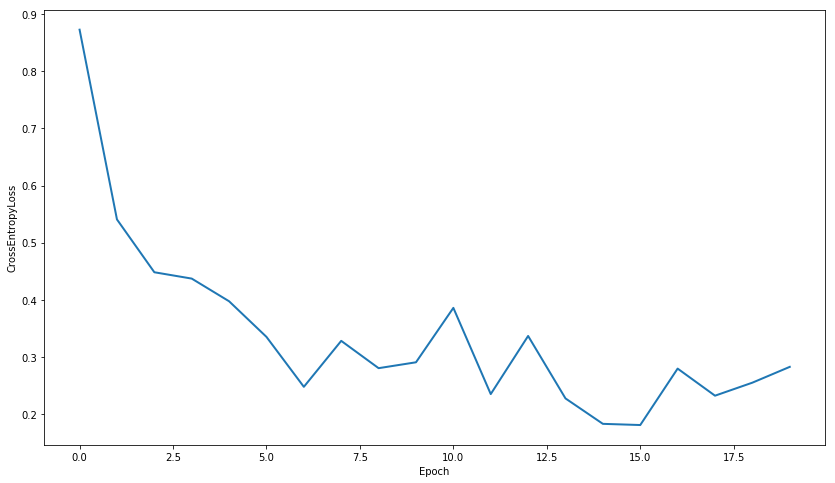

In [5]:
# Visualize
import numpy as np
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(np.arange(epochs), np.array(avg_epoch_loss), linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("CrossEntropyLoss")

C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


torch.Size([2, 128, 256])


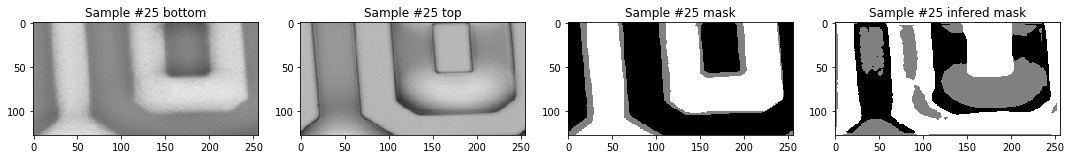

In [35]:
# Infere a sample
i = 25
sample = etching_dataset[i]
image, mask = sample['image'], sample['mask']
infered_mask = infere_model(model, image)
image.squeeze_(0)
print(image.shape)
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(image[0,:,:], cmap='gray',vmin=0, vmax=1)
ax1.set_title('Sample #{} bottom'.format(i))

ax2 = fig.add_subplot(1,4,2)
ax2.imshow(image[1,:,:], cmap='gray',vmin=0, vmax=1)
ax2.set_title('Sample #{} top'.format(i))

ax3 = fig.add_subplot(1,4,3)
ax3.imshow(mask, cmap='gray', vmin=0,vmax=2)
ax3.set_title('Sample #{} mask'.format(i))

ax4 = fig.add_subplot(1,4,4)
ax4.imshow(infered_mask, cmap='gray', vmin=0,vmax=2)
ax4.set_title('Sample #{} infered mask'.format(i))
plt.tight_layout()

In [28]:
infered_mask